In [1]:
!pip install optuna
!pip install catboost==1.2.3
!pip install xgboost==2.0.3
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import os
import gc
import re
import time
import tqdm
import optuna
import holidays
import warnings
import datetime
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, BaseCrossValidator, KFold, RepeatedKFold, GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import SplineTransformer

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

print(f"catboost version: {cb.__version__}")
print(f"lightgbm version: {lgb.__version__}")
print(f"xgboost version: {xgb.__version__}")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

catboost version: 1.2.3
lightgbm version: 4.2.0
xgboost version: 2.0.3


In [3]:
def load_data(config) -> pd.DataFrame:

    train = pd.read_csv(config.train_path)
    test = pd.read_csv(config.test_path)
    df = pd.concat([train, test], axis=0)

    df["sehir"] = df["ilce"].apply(lambda x: x.split('-')[0])
    df["ilce"] = df["ilce"].apply(lambda x: x.split('-')[1])

    df = df.rename(columns={"tarih": "date"})
    df["date"] = pd.to_datetime(df["date"])

    return df

def load_holidays(config) -> pd.DataFrame:
    holidays_df = pd.read_csv(config.holidays_path)

    holidays_df["date"] = holidays_df.apply(
        lambda x: "-".join(
            [str(x["Yıl"]), f"0{str(x['Ay'])}"[-2:], f"0{str(x['Gün'])}"[-2:]]
        ),
        axis=1,
    )

    holidays_df["date"] = pd.to_datetime(holidays_df["date"])

    return holidays_df

def load_weather(config) -> pd.DataFrame:
    weather_df = pd.read_csv(config.weather_path)
    weather_df.rename(columns={'name': 'ilce'},inplace=True)

    weather_df["date_w_hour"] = weather_df["date"]
    weather_df["date"] = pd.to_datetime(weather_df["date"].apply(lambda x: x.split()[0]))

    weather_df["sehir"] = weather_df["ilce"].apply(lambda x: x.split('-')[0].lower())
    weather_df["ilce"] = weather_df["ilce"].apply(lambda x: x.split('-')[1].lower())
    return weather_df

def time_features(dataframe: pd.DataFrame, time_col: str = "Tarih") -> pd.DataFrame:
    """
    Extracts time features from a Pandas DataFrame.

    Args:
        dataframe: A Pandas DataFrame containing a datetime column.
        time_col: The name of the datetime column in the DataFrame.

    Returns:
        A new DataFrame with additional time features.
    """

    df_ = dataframe.copy()

    # Linear Features
    df_["year"] = df_[time_col].dt.year
    df_["month"] = df_[time_col].dt.month
    df_["quarter"] = df_[time_col].dt.quarter
    df_["dayofweek"] = df_[time_col].dt.dayofweek
    df_["dayofyear"] = df_[time_col].dt.dayofyear
    df_["dayofmonth"] = df_[time_col].dt.day
    #df_["weekofyear"] = df_[time_col].dt.weekofyear
    df_["season"] = df_["month"] % 12 // 3 + 1

    # Categorical Features
    df_["is_weekend"] = df_[time_col].apply(lambda x: x.weekday() > 5).astype(int)
    df_["is_month_start"] = df_[time_col].dt.is_month_start.astype(int)
    df_["is_month_end"] = df_[time_col].dt.is_month_end.astype(int)
    df_["is_quarter_start"] = df_[time_col].dt.is_quarter_start.astype(int)
    df_["is_quarter_end"] = df_[time_col].dt.is_quarter_end.astype(int)
    df_["is_year_start"] = df_[time_col].dt.is_year_start.astype(int)
    df_["is_year_end"] = df_[time_col].dt.is_year_end.astype(int)

    # Cyclic Features
    df_["dayofyear_sin"] = np.sin(2 * np.pi * df_["dayofyear"] / df_["dayofyear"].max())
    df_["dayofyear_cos"] = np.cos(2 * np.pi * df_["dayofyear"] / df_["dayofyear"].max())
    df_["month_sin"] = np.sin(2 * np.pi * df_["month"] / df_["month"].max())
    df_["month_cos"] = np.cos(2 * np.pi * df_["month"] / df_["month"].max())

    return df_

def add_holidays(
    dataframe: pd.DataFrame, time_col: str = "Tarih", country: str = "TR"
) -> pd.DataFrame:
    """
    Adds a feature named 'is_holiday' to a Pandas DataFrame,
    representing whether the given date feature is a holiday or not.

    Args:
        dataframe: A Pandas DataFrame containing a date column.
        time_col: The name of the date column in the DataFrame.
        country: The country to use for the list of holidays. Default is 'TR'.

    Returns:
        The modified DataFrame with the 'is_holiday' feature added.
    """
    df_ = dataframe.copy()
    _holidays_ = holidays.country_holidays(country)
    df_["is_holiday"] = df_[time_col].apply(lambda x: x in _holidays_).astype(int)

    return df_

def fix_col_names(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    translation = lambda x: x.translate(x.maketrans("ÜüÖöİıĞğŞşÇç", "UuOoIiGgSsCc"))
    df_.columns = df_.columns.map(lambda x: translation(x).lower().replace(" ", "_"))
    df_ = df_.rename(
        columns={col: re.sub(r"[^A-Za-z0-9_]+", "", col) for col in df_.columns}
    )

    return df_

def lag_features(
    dataframe: pd.DataFrame, cols: list, lags: list, fillna: bool = False
) -> pd.DataFrame:
    df_ = dataframe.copy()
    for col in cols:
        for lag in lags:
            df_[f"{col}_{lag}_lag"] = df_.groupby(["sehir", "ilce"])[col].shift(lag)
            if fillna:
                df_[f"{col}_{lag}_lag"] = df_[f"{col}_{lag}_lag"].fillna(method="bfill")
                df_[f"{col}_{lag}_lag"] = df_[f"{col}_{lag}_lag"].fillna(method="ffill")
    return df_

def reg_trainer(
    model: BaseEstimator,
    X: pd.DataFrame,
    X_test: pd.DataFrame,
    y: pd.Series,
    cv: BaseCrossValidator,
    groups: pd.Series = None,
    train_params: dict = dict(),
    plot_importances: bool = False,
    eval_metric: str = "mse",
    sample_weight: pd.Series = pd.Series(),
    log_transform: bool = False,
) -> dict:

    report = dict()
    if plot_importances == True:
        features = X.columns.tolist()
        feat_imp_df = pd.DataFrame({"feature": features})

    train_oof_preds = np.zeros(shape=(X.shape[0]))
    test_oof_preds = np.zeros(shape=(X_test.shape[0]))

    fitted_models = list()
    fold_scores = list()
    if groups is not None:
        split_fn = cv.split(X=X, y=y, groups=groups)
        n_splits = cv.get_n_splits(X=X, y=y, groups=groups)
    else:
        split_fn = cv.split(X=X, y=y)
        n_splits = cv.get_n_splits(X=X, y=y)
    print(f"n folds: {n_splits}")

    for idx, (train_idx, val_idx) in enumerate(split_fn):
        print(f"| Fold {idx+1} |".center(90, "="))
        start_time = time.time()

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_val, y_val = X.loc[val_idx], y.loc[val_idx]

        if log_transform == True:
            y_train = np.log1p(y_train)
            y_val = np.log1p(y_val)

        if sample_weight.shape[0] > 0:
            fold_sample_weight = sample_weight.loc[train_idx]
            train_params["sample_weight"] = fold_sample_weight

        print(f"train: {X_train.shape}")
        print(f"val: {X_val.shape}")

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            **train_params
        )

        fitted_models.append(model)
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        if log_transform == True:
            val_pred, test_pred = np.expm1(val_pred), np.expm1(test_pred)
            y_train, y_val = np.expm1(y_train), np.expm1(y_val)

        test_oof_preds += test_pred / n_splits
        train_oof_preds[val_idx] = val_pred

        if eval_metric == "mae":
            val_score = mean_absolute_error(y_val, val_pred)
        elif eval_metric == "mape":
            val_score = mean_absolute_percentage_error(y_val, val_pred)
        elif eval_metric == "mse":
            val_score = mean_squared_error(y_val, val_pred)
        elif eval_metric == "rmse":
            val_score = mean_squared_error(y_val, val_pred, squared=False)
        else:
            val_score = mean_squared_error(y_val, val_pred)
        fold_scores.append(val_score)

        if plot_importances == True:
            feat_imp_df = feat_imp_df.merge(
                pd.DataFrame(
                    {
                        "feature": features,
                        f"fold_{idx+1}_feat_imp": model.feature_importances_,
                    }
                ),
                on=["feature"],
                how="left",
            )

        end_time = time.time()
        elapsed = end_time - start_time

        print(f"Fold {eval_metric}: {val_score:.5f}")
        print(f"Elapsed: {elapsed:.2f} seconds\n")

    print("=" * 90)
    print(f"CV: {np.mean(fold_scores):.5f}")

    report["fitted_models"] = fitted_models
    report["train_preds"] = train_oof_preds
    report["test_preds"] = test_oof_preds
    report["fold_scores"] = fold_scores

    if plot_importances == True:
        feat_imp_df["avg_importance"] = feat_imp_df.iloc[:, 1:].mean(axis=1)
        plt.figure(figsize=(12, 10))
        sns.barplot(
            data=feat_imp_df.sort_values(by="avg_importance", ascending=False).iloc[
                :50
            ],
            x="avg_importance",
            y="feature",
            color="royalblue",
            width=0.75,
        )
        plt.title("Average Feature Importances for All Folds", size=12)
        plt.show()

        report["feature_importances"] = feat_imp_df

    return report

In [4]:
class config:
    root = "/kaggle/input/gdz-elektrik-datathon-2024"
    holidays_path = os.path.join(root, "holidays.csv")
    sample_submission_path = os.path.join(root, "sample_submission.csv")
    weather_path = os.path.join(root, "weather.csv")
    train_path = os.path.join(root, "train.csv")
    test_path = os.path.join(root, "test.csv")

In [5]:
df = load_data(config)

weather_df = load_weather(config)

In [6]:
weather_df["t_diff"] = weather_df["t_2m:C"] - weather_df["t_apparent:C"]

weather_df["wind_chill"] = (
    35.74
    + 0.6215 * weather_df["t_2m:C"]
    - 35.75 * (weather_df["wind_speed_10m:ms"] ** 0.16)
    + 0.4275 * weather_df["t_2m:C"] * (weather_df["wind_speed_10m:ms"] ** 0.16)
)

weather_df["dew_point"] = weather_df["t_2m:C"] - (
    (100 - weather_df["relative_humidity_2m:p"]) / 5
)

weather_df["wind_speed_direction"] = (
    weather_df["wind_speed_10m:ms"] * weather_df["wind_dir_10m:d"]
)

weather_df["solar_temp_interaction"] = weather_df["global_rad:W"] * weather_df["t_2m:C"]

weather_df["cloud_humidity_interaction"] = (
    weather_df["effective_cloud_cover:p"] * weather_df["relative_humidity_2m:p"]
)

weather_df["sicaklik_nem_orani"] = (
    weather_df["t_2m:C"] * weather_df["relative_humidity_2m:p"] / 100
)


weather_df["sicaklik_ruzgar_etkilesimi"] = (
    weather_df["t_2m:C"] * weather_df["wind_speed_10m:ms"]
)

weather_df["ters_etkilesim_yagis_gunes"] = (
    weather_df["global_rad:W"] * weather_df["prob_precip_1h:p"] * -1
)

weather_df["heat_index_C"] = (
    -8.78469475556
    + 1.61139411 * weather_df["t_2m:C"]
    + 2.33854883889 * weather_df["relative_humidity_2m:p"]
    - 0.14611605 * weather_df["t_2m:C"] * weather_df["relative_humidity_2m:p"]
    - 0.012308094 * weather_df["t_2m:C"] ** 2
    - 0.0164248277778 * weather_df["relative_humidity_2m:p"] ** 2
    + 0.002211732 * weather_df["t_2m:C"] ** 2 * weather_df["relative_humidity_2m:p"]
    + 0.00072546 * weather_df["t_2m:C"] * weather_df["relative_humidity_2m:p"] ** 2
    - 0.000003582
    * weather_df["t_2m:C"] ** 2
    * weather_df["relative_humidity_2m:p"] ** 2
)

In [7]:
weather_aggs = {
    "t_2m:C": ["mean", "max", "min", "std"],
    "effective_cloud_cover:p": ["mean", "max", "min", "std"],
    "global_rad:W": ["mean", "max", "min", "std", "sum"],
    "relative_humidity_2m:p": ["mean", "max", "min", "std"],
    "wind_dir_10m:d": ["mean", "max", "min", "std"],
    "wind_speed_10m:ms": ["mean", "max", "min", "std"],
    "prob_precip_1h:p": ["mean", "max", "min", "std", "var"],
    "t_apparent:C": ["mean", "max", "min", "std"],
    "t_diff": ["mean", "max", "min", "std"],
    'wind_chill': ["mean", "max", "min", "std"],
    'dew_point': ["mean", "max", "min", "std"],
    'wind_speed_direction': ["mean", "max", "min", "std"],
    'solar_temp_interaction': ["mean", "max", "min", "std"],
    'cloud_humidity_interaction': ["mean", "max", "min", "std"],
    'sicaklik_nem_orani': ["mean", "max", "min", "std"],
    'sicaklik_ruzgar_etkilesimi': ["mean", "max", "min", "std"],
    'ters_etkilesim_yagis_gunes':["mean", "max", "min", "std"],
    'heat_index_C':["mean", "max", "min", "std"]
}


for field, agg_list in weather_aggs.items():
    for agg in agg_list:
        df = df.merge(
            weather_df.groupby(["date", "sehir", "ilce"], as_index=False).agg(
                **{f"{field}_{agg}": (field, agg)}
            ),
            on=["date", "sehir", "ilce"],
            how="left",
        )

df['temp_range'] = df['t_2m:C_max'] - df['t_2m:C_min']
df['wind_speed_10m_range'] = df['wind_speed_10m:ms_max'] - df['wind_speed_10m:ms_min']
df['wind_dir_10m_range'] = df['wind_dir_10m:d_max'] - df['wind_dir_10m:d_min']
df['relative_humidity_2m_range'] = df['relative_humidity_2m:p_max'] - df['relative_humidity_2m:p_min']
df['effective_cloud_cover_range'] = df['effective_cloud_cover:p_max'] - df['effective_cloud_cover:p_min']
df['global_rad_range'] = df['global_rad:W_max'] - df['global_rad:W_min']
df['t_apparent_range'] = df['t_apparent:C_max'] - df['t_apparent:C_min']

df = df.merge(
    weather_df[["sehir", "ilce", "lat", "lon"]].drop_duplicates(),
    on=["sehir", "ilce"],
    how="left"
)

print(df.shape)
df.head()

(49511, 88)


,date,ilce,bildirimsiz_sum,bildirimli_sum,sehir,t_2m:C_mean,t_2m:C_max,t_2m:C_min,t_2m:C_std,effective_cloud_cover:p_mean,...,heat_index_C_std,temp_range,wind_speed_10m_range,wind_dir_10m_range,relative_humidity_2m_range,effective_cloud_cover_range,global_rad_range,t_apparent_range,lat,lon
0,2021-01-01,aliaga,5.0,0,izmir,13.275000,15.8,11.3,1.305923,55.045833,...,0.972472,4.5,4.6,66.5,16.1,72.4,338.4,7.1,38.7996,26.9707
1,2021-01-02,aliaga,13.0,0,izmir,12.870833,17.2,10.6,2.377883,36.125000,...,1.099864,6.6,1.9,31.4,30.1,46.7,401.7,9.1,38.7996,26.9707
2,2021-01-03,aliaga,4.0,0,izmir,12.633333,15.9,11.1,1.351864,64.870833,...,2.094852,4.8,1.4,36.6,11.6,78.1,176.1,6.3,38.7996,26.9707
3,2021-01-04,aliaga,9.0,0,izmir,13.733333,17.0,11.0,2.388317,47.783333,...,1.936143,6.0,3.7,59.7,24.8,59.8,367.1,6.9,38.7996,26.9707
4,2021-01-05,aliaga,2.0,0,izmir,14.375000,16.8,12.2,1.522655,30.379167,...,2.619268,4.6,6.6,118.5,39.6,99.0,409.0,7.6,38.7996,26.9707


## Holidays

In [8]:
holidays_df = load_holidays(config)

holidays_df.head()

,Yıl,Ay,Gün,Tatil Adı,date
0,2021,1,1,New Year's Day,2021-01-01
1,2021,4,23,National Sovereignty and Children's Day,2021-04-23
2,2021,5,1,Labour Day,2021-05-01
3,2021,5,19,"Commemoration of Ataturk, Youth and Sports Day",2021-05-19
4,2021,7,15,Democracy and National Unity Day,2021-07-15


In [9]:
df = pd.get_dummies(
    data=df.merge(
        holidays_df[["Tatil Adı", "date"]], on=["date"], how="left"
    ).assign(is_bayram=lambda x: (x["Tatil Adı"].notnull()).astype("int32")),
    columns=["Tatil Adı"],
    dtype="int32",
)

df['milli_bayram_flag'] = df[['Tatil Adı_Commemoration of Ataturk, Youth and Sports Day',
                              'Tatil Adı_Commemoration of Ataturk, Youth and Sports Day',
                              'Tatil Adı_Democracy and National Unity Day',
                              "Tatil Adı_National Sovereignty and Children's Day",
                              'Tatil Adı_Republic Day',
                              'Tatil Adı_Victory Day']].max(axis=1)

df['dini_bayram_flag'] = df[['Tatil Adı_Ramadan Feast Holiday* (*estimated)',
                             'Tatil Adı_Ramadan Feast* (*estimated)',
                             'Tatil Adı_Sacrifice Feast Holiday* (*estimated)',
                             'Tatil Adı_Sacrifice Feast* (*estimated)']].max(axis=1)

df.head()

,date,ilce,bildirimsiz_sum,bildirimli_sum,sehir,t_2m:C_mean,t_2m:C_max,t_2m:C_min,t_2m:C_std,effective_cloud_cover:p_mean,...,Tatil Adı_National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated),Tatil Adı_New Year's Day,Tatil Adı_Ramadan Feast Holiday* (*estimated),Tatil Adı_Ramadan Feast* (*estimated),Tatil Adı_Republic Day,Tatil Adı_Sacrifice Feast Holiday* (*estimated),Tatil Adı_Sacrifice Feast* (*estimated),Tatil Adı_Victory Day,milli_bayram_flag,dini_bayram_flag
0,2021-01-01,aliaga,5.0,0,izmir,13.275000,15.8,11.3,1.305923,55.045833,...,0,1,0,0,0,0,0,0,0,0
1,2021-01-02,aliaga,13.0,0,izmir,12.870833,17.2,10.6,2.377883,36.125000,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-03,aliaga,4.0,0,izmir,12.633333,15.9,11.1,1.351864,64.870833,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-04,aliaga,9.0,0,izmir,13.733333,17.0,11.0,2.388317,47.783333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-05,aliaga,2.0,0,izmir,14.375000,16.8,12.2,1.522655,30.379167,...,0,0,0,0,0,0,0,0,0,0


## Creating Sample Weights

In [10]:
sample_weight_df = pd.DataFrame()
for i, j in df[["sehir", "ilce"]].drop_duplicates().iterrows():
    sehir, ilce = j["sehir"], j["ilce"]

    train_dates = df.loc[
        (df["bildirimsiz_sum"].notnull())
        & (df["sehir"] == sehir)
        & (df["ilce"] == ilce),
        "date",
    ].sort_values(ascending=True)

    space = np.linspace(start=0.05, stop=0.95, num=train_dates.nunique())
    replace_dict = {
        train_dates.unique()[i]: space[i] for i in range(len(train_dates.unique()))
    }
    sample_weight = train_dates.apply(lambda x: replace_dict[x])

    sample_weight_df = pd.concat(
        [
            sample_weight_df,
            pd.DataFrame(
                {
                    "sehir": sehir,
                    "ilce": ilce,
                    "date": train_dates,
                    "sample_weight": sample_weight,
                }
            ),
        ],
        axis=0,
    )

df = df.merge(sample_weight_df, on=["sehir", "ilce", "date"], how="left")
df.head()

,date,ilce,bildirimsiz_sum,bildirimli_sum,sehir,t_2m:C_mean,t_2m:C_max,t_2m:C_min,t_2m:C_std,effective_cloud_cover:p_mean,...,Tatil Adı_New Year's Day,Tatil Adı_Ramadan Feast Holiday* (*estimated),Tatil Adı_Ramadan Feast* (*estimated),Tatil Adı_Republic Day,Tatil Adı_Sacrifice Feast Holiday* (*estimated),Tatil Adı_Sacrifice Feast* (*estimated),Tatil Adı_Victory Day,milli_bayram_flag,dini_bayram_flag,sample_weight
0,2021-01-01,aliaga,5.0,0,izmir,13.275000,15.8,11.3,1.305923,55.045833,...,1,0,0,0,0,0,0,0,0,0.050000
1,2021-01-02,aliaga,13.0,0,izmir,12.870833,17.2,10.6,2.377883,36.125000,...,0,0,0,0,0,0,0,0,0,0.050814
2,2021-01-03,aliaga,4.0,0,izmir,12.633333,15.9,11.1,1.351864,64.870833,...,0,0,0,0,0,0,0,0,0,0.051629
3,2021-01-04,aliaga,9.0,0,izmir,13.733333,17.0,11.0,2.388317,47.783333,...,0,0,0,0,0,0,0,0,0,0.052443
4,2021-01-05,aliaga,2.0,0,izmir,14.375000,16.8,12.2,1.522655,30.379167,...,0,0,0,0,0,0,0,0,0,0.053258


## Time Features

In [11]:
df = time_features(df, "date")

## Adding Custom Seasonal Features

In [12]:
spline1 = SplineTransformer(degree=2, n_knots=2)

df = pd.concat([df, pd.DataFrame(spline1.fit_transform(df[["dayofyear"]]), columns=spline1.get_feature_names_out())], axis=1)

spline2 = SplineTransformer(degree=2, n_knots=2)

df = pd.concat([df, pd.DataFrame(spline2.fit_transform(df[["dayofmonth"]]), columns=spline2.get_feature_names_out())], axis=1)

spline3 = SplineTransformer(degree=2, n_knots=2)

df = pd.concat([df, pd.DataFrame(spline3.fit_transform(df[["dayofweek"]]), columns=spline3.get_feature_names_out())], axis=1)

df.head()

,date,ilce,bildirimsiz_sum,bildirimli_sum,sehir,t_2m:C_mean,t_2m:C_max,t_2m:C_min,t_2m:C_std,effective_cloud_cover:p_mean,...,month_cos,dayofyear_sp_0,dayofyear_sp_1,dayofyear_sp_2,dayofmonth_sp_0,dayofmonth_sp_1,dayofmonth_sp_2,dayofweek_sp_0,dayofweek_sp_1,dayofweek_sp_2
0,2021-01-01,aliaga,5.0,0,izmir,13.275000,15.8,11.3,1.305923,55.045833,...,0.866025,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.055556,0.722222,0.222222
1,2021-01-02,aliaga,13.0,0,izmir,12.870833,17.2,10.6,2.377883,36.125000,...,0.866025,0.497257,0.502740,0.000004,0.467222,0.532222,0.000556,0.013889,0.638889,0.347222
2,2021-01-03,aliaga,4.0,0,izmir,12.633333,15.9,11.1,1.351864,64.870833,...,0.866025,0.494521,0.505464,0.000015,0.435556,0.562222,0.002222,0.000000,0.500000,0.500000
3,2021-01-04,aliaga,9.0,0,izmir,13.733333,17.0,11.0,2.388317,47.783333,...,0.866025,0.491792,0.508174,0.000034,0.405000,0.590000,0.005000,0.500000,0.500000,0.000000
4,2021-01-05,aliaga,2.0,0,izmir,14.375000,16.8,12.2,1.522655,30.379167,...,0.866025,0.489071,0.510868,0.000060,0.375556,0.615556,0.008889,0.347222,0.638889,0.013889


## Handling Outliers

In [13]:
ilce_df_all = pd.DataFrame()
for ilce in sorted(df["ilce"].unique()):
    ilce_df = df.loc[df["ilce"] == ilce, ["date", "bildirimsiz_sum"]].sort_values("date", ascending=True).dropna()

    q3 = ilce_df["bildirimsiz_sum"].quantile(0.9)
    q1 = ilce_df["bildirimsiz_sum"].quantile(0.1)
    iqr = q3 -  q1
    upper_limit = q3 + 1.5 * iqr

    ilce_df["is_anomaly"] = np.nan
    ilce_df["bildirimsiz_sum_fixed"] = ilce_df["bildirimsiz_sum"]
    ilce_df.loc[ilce_df["bildirimsiz_sum_fixed"] > upper_limit, "is_anomaly"] = 1
    ilce_df.loc[ilce_df["bildirimsiz_sum_fixed"] > upper_limit, "bildirimsiz_sum_fixed"] = upper_limit
    ilce_df["is_anomaly"] = ilce_df["is_anomaly"].fillna(0)
    ilce_df.loc[ilce_df["is_anomaly"] == 1, "bildirimsiz_sum_fixed"] = ilce_df.loc[ilce_df["is_anomaly"] == 1, "bildirimsiz_sum"] * 0.38 + ilce_df.loc[ilce_df["is_anomaly"] == 1, "bildirimsiz_sum_fixed"] * 0.62
    ilce_df["ilce"] = ilce

    #plt.figure(figsize=(10, 4))
    #sns.lineplot(data=ilce_df, x="date", y="bildirimsiz_sum", color="royalblue")
    #sns.lineplot(data=ilce_df, x="date", y="bildirimsiz_sum_fixed", color="darkorange")
    #plt.title(f"ilce: {ilce}")
    #plt.show()

    ilce_df_all = pd.concat([ilce_df_all, ilce_df[["date", "ilce", "bildirimsiz_sum_fixed"]]], axis=0)
ilce_df_all.head()

,date,ilce,bildirimsiz_sum_fixed
47526,2021-01-05,ahmetli,2.0
47527,2021-01-06,ahmetli,1.0
47528,2021-01-07,ahmetli,2.0
47529,2021-01-09,ahmetli,1.0
47530,2021-01-10,ahmetli,2.0


In [14]:
df = df.merge(ilce_df_all, on=["date", "ilce"], how="left")

df.head()

,date,ilce,bildirimsiz_sum,bildirimli_sum,sehir,t_2m:C_mean,t_2m:C_max,t_2m:C_min,t_2m:C_std,effective_cloud_cover:p_mean,...,dayofyear_sp_0,dayofyear_sp_1,dayofyear_sp_2,dayofmonth_sp_0,dayofmonth_sp_1,dayofmonth_sp_2,dayofweek_sp_0,dayofweek_sp_1,dayofweek_sp_2,bildirimsiz_sum_fixed
0,2021-01-01,aliaga,5.0,0,izmir,13.275000,15.8,11.3,1.305923,55.045833,...,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.055556,0.722222,0.222222,5.0
1,2021-01-02,aliaga,13.0,0,izmir,12.870833,17.2,10.6,2.377883,36.125000,...,0.497257,0.502740,0.000004,0.467222,0.532222,0.000556,0.013889,0.638889,0.347222,13.0
2,2021-01-03,aliaga,4.0,0,izmir,12.633333,15.9,11.1,1.351864,64.870833,...,0.494521,0.505464,0.000015,0.435556,0.562222,0.002222,0.000000,0.500000,0.500000,4.0
3,2021-01-04,aliaga,9.0,0,izmir,13.733333,17.0,11.0,2.388317,47.783333,...,0.491792,0.508174,0.000034,0.405000,0.590000,0.005000,0.500000,0.500000,0.000000,9.0
4,2021-01-05,aliaga,2.0,0,izmir,14.375000,16.8,12.2,1.522655,30.379167,...,0.489071,0.510868,0.000060,0.375556,0.615556,0.008889,0.347222,0.638889,0.013889,2.0


## Modelling

In [15]:
target = "bildirimsiz_sum_fixed"
drop_cols = ["date", "sample_weight", "lat", "lon", "bildirimsiz_sum"]
cat_cols = ["ilce", "sehir", "year", "season"]

for col in cat_cols:
    df[col] = df[col].astype(str).astype("category")

df = fix_col_names(df)
sample_weight = df["sample_weight"]

X = df.loc[df[target].notnull()].drop(columns = drop_cols + [target], axis=1)
y = df.loc[df[target].notnull(), target]
X_test = df.loc[df[target].isnull()].drop(columns = drop_cols + [target], axis=1)

test_date = df.loc[df[target].isnull(), "date"]
test_ilce = df.loc[df[target].isnull(), "ilce"]

## Prophet

In [16]:
def load_prophet_model():
    model = Prophet(
        growth="linear",
        #seasonality_prior_scale=0.5,
        weekly_seasonality="auto",
        yearly_seasonality="auto",
        daily_seasonality="auto",
                   )
    #model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    #model.add_seasonality(name='weekly', period=7, fourier_order=3)
    model.add_country_holidays(country_name="TR")
    return model

train = df.loc[df[target].notnull()].reset_index(drop=True)
test = df.loc[df[target].isnull()].reset_index(drop=True)
prophet_score = list()
prophet_preds = pd.DataFrame()

test_all_dates = pd.DataFrame()
for ilce in sorted(df["ilce"].unique()):
    print(f"ilce: {ilce}")

    g_train_df = train.loc[train["ilce"] == ilce, ["ilce", "date", target]].sort_values("date").copy()
    g_test_df = test.loc[test["ilce"] == ilce, ["ilce", "date", target]].sort_values("date").copy()

    g_train_df = g_train_df.reset_index(drop=True)
    g_test_df = g_test_df.reset_index(drop=True)

    test_dates = g_test_df[["date"]].copy()
    print("train:", g_train_df.shape)
    print("test:", g_test_df.shape)
    print(f"val: {g_train_df.iloc[int(g_train_df.shape[0]*0.95):].shape}")

    # Model Validation

    #model = load_prophet_model()
    #model.fit(g_train_df.iloc[i:int(g_train_df.shape[0]*0.95)].rename(columns={"date": "ds", target: "y"}))
    #val_pred_df = model.predict(df=g_train_df.iloc[int(g_train_df.shape[0]*0.95):].rename(columns={"date": "ds"}))

    #val_yhat_upper = val_pred_df["yhat_upper"].values
    #val_yhat_lower = val_pred_df["yhat_lower"].values
    #val_pred = val_yhat_upper * 0.36 + val_yhat_lower * 0.64
    #val_pred = val_pred.clip(0, np.inf)

    #val_pred_list = list()
    #for i in range(0, 30*6+1, 30):
    #    print(i)
    model = load_prophet_model()
    model.fit(g_train_df.iloc[:int(g_train_df.shape[0]*0.95)].rename(columns={"date": "ds", target: "y"}))
    val_pred_df = model.predict(df=g_train_df.iloc[int(g_train_df.shape[0]*0.95):].rename(columns={"date": "ds"}))

    val_yhat_upper = val_pred_df["yhat_upper"].values
    val_yhat_lower = val_pred_df["yhat_lower"].values
    val_pred = val_yhat_upper * 0.36 + val_yhat_lower * 0.64
    val_pred = val_pred.clip(0, np.inf)
    #val_pred_list.append(val_pred)

    #val_pred = np.mean(val_pred_list, axis=0)
    val_mae = mean_absolute_error(g_train_df.iloc[int(g_train_df.shape[0]*0.95):][target], val_pred)
    prophet_score.append(val_mae)
    print(f"val mae: {val_mae:.5f}")

    # Model Training

    #test_pred_list = list()
    #for i in range(0, 30*6+1, 30):
    #print(i)
    model = load_prophet_model()
    model.fit(g_train_df.iloc[:].rename(columns={"date": "ds", target: "y"}))
    test_pred_df = model.predict(df=g_test_df.rename(columns={"date": "ds"}))

    test_yhat_upper = test_pred_df["yhat_upper"].values
    test_yhat_lower = test_pred_df["yhat_lower"].values
    test_pred = test_yhat_upper * 0.36 + test_yhat_lower * 0.64
    test_pred = test_pred.clip(0, np.inf)
    #test_pred_list.append(val_pred)

    #test_pred = np.mean(test_pred_list, axis=0)
    test_dates["prophet_pred"] = test_pred
    test_dates["ilce"] = ilce
    prophet_preds = pd.concat([prophet_preds, test_dates], axis=0)

    del g_train_df, g_test_df, model, test_pred_df, val_pred_df
    _ = gc.collect()

    print("="*60)

#Prophet CV: 2.97670
#Prophet CV: 2.94594 #seasonalities removed

# Prophet CV: 2.80394 -> val_pred = val_yhat_upper * 0.45 + val_yhat_lower * 0.55
# Prophet CV: 3.13949 -> val_pred = val_yhat_upper * 0.55 + val_yhat_lower * 0.45
# Prophet CV: 2.73009 -> val_pred = val_yhat_upper * 0.4 + val_yhat_lower * 0.6
# Prophet CV: 2.71085 -> val_pred = val_yhat_upper * 0.36 + val_yhat_lower * 0.64
# Prophet CV: 2.70694 -> seasonality_prior_scale=0.5,

# Prophet CV: 2.71485 -> seasonality_prior_scale=0.5,

# 4 folds Prophet CV: 2.68482
# 6 folds Prophet CV: 2.67565

print(f"Prophet CV: {np.mean(prophet_score):.5f}")
prophet_preds = test[["date", "ilce"]].merge(prophet_preds, on=["ilce", "date"], how="left")
prophet_preds.head()

ilce: ahmetli
train: (622, 3)
test: (29, 3)
val: (32, 3)


15:45:22 - cmdstanpy - INFO - Chain [1] start processing
15:45:22 - cmdstanpy - INFO - Chain [1] done processing
15:45:23 - cmdstanpy - INFO - Chain [1] start processing
15:45:23 - cmdstanpy - INFO - Chain [1] done processing


val mae: 0.80535


15:45:24 - cmdstanpy - INFO - Chain [1] start processing


ilce: akhisar
train: (1126, 3)
test: (29, 3)
val: (57, 3)


15:45:24 - cmdstanpy - INFO - Chain [1] done processing
15:45:24 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.28220


15:45:24 - cmdstanpy - INFO - Chain [1] done processing
15:45:25 - cmdstanpy - INFO - Chain [1] start processing


ilce: alasehir
train: (1119, 3)
test: (29, 3)
val: (56, 3)


15:45:25 - cmdstanpy - INFO - Chain [1] done processing
15:45:26 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.19489


15:45:26 - cmdstanpy - INFO - Chain [1] done processing
15:45:26 - cmdstanpy - INFO - Chain [1] start processing


ilce: aliaga
train: (1106, 3)
test: (29, 3)
val: (56, 3)


15:45:27 - cmdstanpy - INFO - Chain [1] done processing
15:45:27 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.15747


15:45:27 - cmdstanpy - INFO - Chain [1] done processing
15:45:28 - cmdstanpy - INFO - Chain [1] start processing
15:45:28 - cmdstanpy - INFO - Chain [1] done processing


ilce: balcova
train: (698, 3)
test: (29, 3)
val: (35, 3)


15:45:29 - cmdstanpy - INFO - Chain [1] start processing


val mae: 0.84930


15:45:29 - cmdstanpy - INFO - Chain [1] done processing
15:45:29 - cmdstanpy - INFO - Chain [1] start processing


ilce: bayindir
train: (1105, 3)
test: (29, 3)
val: (56, 3)


15:45:30 - cmdstanpy - INFO - Chain [1] done processing
15:45:30 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.83506


15:45:30 - cmdstanpy - INFO - Chain [1] done processing
15:45:31 - cmdstanpy - INFO - Chain [1] start processing


ilce: bayrakli
train: (1086, 3)
test: (29, 3)
val: (55, 3)


15:45:31 - cmdstanpy - INFO - Chain [1] done processing
15:45:32 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.45256


15:45:32 - cmdstanpy - INFO - Chain [1] done processing
15:45:32 - cmdstanpy - INFO - Chain [1] start processing


ilce: bergama
train: (1120, 3)
test: (29, 3)
val: (56, 3)


15:45:32 - cmdstanpy - INFO - Chain [1] done processing
15:45:33 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.88946


15:45:33 - cmdstanpy - INFO - Chain [1] done processing
15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] done processing


ilce: beydag
train: (673, 3)
test: (29, 3)
val: (34, 3)


15:45:34 - cmdstanpy - INFO - Chain [1] start processing
15:45:34 - cmdstanpy - INFO - Chain [1] done processing


val mae: 1.92022


15:45:35 - cmdstanpy - INFO - Chain [1] start processing


ilce: bornova
train: (1124, 3)
test: (29, 3)
val: (57, 3)


15:45:35 - cmdstanpy - INFO - Chain [1] done processing
15:45:36 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.95138


15:45:36 - cmdstanpy - INFO - Chain [1] done processing
15:45:37 - cmdstanpy - INFO - Chain [1] start processing


ilce: buca
train: (1115, 3)
test: (29, 3)
val: (56, 3)


15:45:37 - cmdstanpy - INFO - Chain [1] done processing
15:45:37 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.58607


15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:38 - cmdstanpy - INFO - Chain [1] start processing


ilce: cesme
train: (1125, 3)
test: (29, 3)
val: (57, 3)


15:45:38 - cmdstanpy - INFO - Chain [1] done processing
15:45:39 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.87174


15:45:39 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing


ilce: cigli
train: (1071, 3)
test: (29, 3)
val: (54, 3)


15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:40 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.58718


15:45:40 - cmdstanpy - INFO - Chain [1] done processing
15:45:41 - cmdstanpy - INFO - Chain [1] start processing


ilce: demirci
train: (938, 3)
test: (29, 3)
val: (47, 3)


15:45:41 - cmdstanpy - INFO - Chain [1] done processing
15:45:42 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.66820


15:45:42 - cmdstanpy - INFO - Chain [1] done processing
15:45:43 - cmdstanpy - INFO - Chain [1] start processing


ilce: dikili
train: (1119, 3)
test: (29, 3)
val: (56, 3)


15:45:43 - cmdstanpy - INFO - Chain [1] done processing
15:45:43 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.51073


15:45:43 - cmdstanpy - INFO - Chain [1] done processing
15:45:44 - cmdstanpy - INFO - Chain [1] start processing


ilce: foca
train: (1086, 3)
test: (29, 3)
val: (55, 3)


15:45:44 - cmdstanpy - INFO - Chain [1] done processing
15:45:45 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.96104


15:45:45 - cmdstanpy - INFO - Chain [1] done processing
15:45:46 - cmdstanpy - INFO - Chain [1] start processing
15:45:46 - cmdstanpy - INFO - Chain [1] done processing


ilce: gaziemir
train: (920, 3)
test: (29, 3)
val: (46, 3)


15:45:46 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.62332


15:45:46 - cmdstanpy - INFO - Chain [1] done processing
15:45:47 - cmdstanpy - INFO - Chain [1] start processing
15:45:47 - cmdstanpy - INFO - Chain [1] done processing


ilce: golmarmara
train: (566, 3)
test: (29, 3)
val: (29, 3)


15:45:48 - cmdstanpy - INFO - Chain [1] start processing
15:45:48 - cmdstanpy - INFO - Chain [1] done processing


val mae: 0.45545


15:45:49 - cmdstanpy - INFO - Chain [1] start processing


ilce: gordes
train: (1059, 3)
test: (29, 3)
val: (53, 3)


15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:49 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.90843


15:45:49 - cmdstanpy - INFO - Chain [1] done processing
15:45:50 - cmdstanpy - INFO - Chain [1] start processing


ilce: guzelbahce
train: (856, 3)
test: (29, 3)
val: (43, 3)


15:45:50 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.53591


15:45:51 - cmdstanpy - INFO - Chain [1] done processing
15:45:51 - cmdstanpy - INFO - Chain [1] start processing


ilce: karabaglar
train: (1100, 3)
test: (29, 3)
val: (55, 3)


15:45:52 - cmdstanpy - INFO - Chain [1] done processing
15:45:52 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.00573


15:45:52 - cmdstanpy - INFO - Chain [1] done processing
15:45:53 - cmdstanpy - INFO - Chain [1] start processing


ilce: karaburun
train: (1089, 3)
test: (29, 3)
val: (55, 3)


15:45:53 - cmdstanpy - INFO - Chain [1] done processing
15:45:54 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.81716


15:45:54 - cmdstanpy - INFO - Chain [1] done processing
15:45:55 - cmdstanpy - INFO - Chain [1] start processing


ilce: karsiyaka
train: (1085, 3)
test: (29, 3)
val: (55, 3)


15:45:55 - cmdstanpy - INFO - Chain [1] done processing
15:45:55 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.19459


15:45:55 - cmdstanpy - INFO - Chain [1] done processing
15:45:56 - cmdstanpy - INFO - Chain [1] start processing


ilce: kemalpasa
train: (1118, 3)
test: (29, 3)
val: (56, 3)


15:45:56 - cmdstanpy - INFO - Chain [1] done processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.56682


15:45:57 - cmdstanpy - INFO - Chain [1] done processing
15:45:57 - cmdstanpy - INFO - Chain [1] start processing


ilce: kinik
train: (914, 3)
test: (29, 3)
val: (46, 3)


15:45:58 - cmdstanpy - INFO - Chain [1] done processing
15:45:58 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.58566


15:45:58 - cmdstanpy - INFO - Chain [1] done processing
15:45:59 - cmdstanpy - INFO - Chain [1] start processing


ilce: kiraz
train: (1097, 3)
test: (29, 3)
val: (55, 3)


15:45:59 - cmdstanpy - INFO - Chain [1] done processing
15:46:00 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.29581


15:46:00 - cmdstanpy - INFO - Chain [1] done processing
15:46:00 - cmdstanpy - INFO - Chain [1] start processing
15:46:01 - cmdstanpy - INFO - Chain [1] done processing


ilce: kirkagac
train: (950, 3)
test: (29, 3)
val: (48, 3)


15:46:01 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.63961


15:46:01 - cmdstanpy - INFO - Chain [1] done processing
15:46:02 - cmdstanpy - INFO - Chain [1] start processing


ilce: konak
train: (1124, 3)
test: (29, 3)
val: (57, 3)


15:46:02 - cmdstanpy - INFO - Chain [1] done processing
15:46:02 - cmdstanpy - INFO - Chain [1] start processing


val mae: 5.56890


15:46:03 - cmdstanpy - INFO - Chain [1] done processing
15:46:03 - cmdstanpy - INFO - Chain [1] start processing
15:46:03 - cmdstanpy - INFO - Chain [1] done processing


ilce: koprubasi
train: (805, 3)
test: (29, 3)
val: (41, 3)


15:46:04 - cmdstanpy - INFO - Chain [1] start processing
15:46:04 - cmdstanpy - INFO - Chain [1] done processing


val mae: 1.36789


15:46:05 - cmdstanpy - INFO - Chain [1] start processing


ilce: kula
train: (1039, 3)
test: (29, 3)
val: (52, 3)


15:46:05 - cmdstanpy - INFO - Chain [1] done processing
15:46:05 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.09493


15:46:05 - cmdstanpy - INFO - Chain [1] done processing
15:46:06 - cmdstanpy - INFO - Chain [1] start processing


ilce: menderes
train: (1125, 3)
test: (29, 3)
val: (57, 3)


15:46:06 - cmdstanpy - INFO - Chain [1] done processing
15:46:07 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.02798


15:46:07 - cmdstanpy - INFO - Chain [1] done processing
15:46:08 - cmdstanpy - INFO - Chain [1] start processing


ilce: menemen
train: (1119, 3)
test: (29, 3)
val: (56, 3)


15:46:08 - cmdstanpy - INFO - Chain [1] done processing
15:46:08 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.99588


15:46:08 - cmdstanpy - INFO - Chain [1] done processing
15:46:09 - cmdstanpy - INFO - Chain [1] start processing


ilce: narlidere
train: (783, 3)
test: (29, 3)
val: (40, 3)


15:46:09 - cmdstanpy - INFO - Chain [1] done processing
15:46:10 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.31250


15:46:10 - cmdstanpy - INFO - Chain [1] done processing
15:46:11 - cmdstanpy - INFO - Chain [1] start processing


ilce: odemis
train: (1124, 3)
test: (29, 3)
val: (57, 3)


15:46:11 - cmdstanpy - INFO - Chain [1] done processing
15:46:11 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.42570


15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:12 - cmdstanpy - INFO - Chain [1] start processing


ilce: salihli
train: (1126, 3)
test: (29, 3)
val: (57, 3)


15:46:12 - cmdstanpy - INFO - Chain [1] done processing
15:46:13 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.70213


15:46:13 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing


ilce: sarigol
train: (1027, 3)
test: (29, 3)
val: (52, 3)


15:46:14 - cmdstanpy - INFO - Chain [1] done processing
15:46:14 - cmdstanpy - INFO - Chain [1] start processing
15:46:14 - cmdstanpy - INFO - Chain [1] done processing


val mae: 1.85394


15:46:15 - cmdstanpy - INFO - Chain [1] start processing


ilce: saruhanli
train: (1105, 3)
test: (29, 3)
val: (56, 3)


15:46:15 - cmdstanpy - INFO - Chain [1] done processing
15:46:16 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.92395


15:46:16 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] start processing


ilce: seferihisar
train: (1111, 3)
test: (29, 3)
val: (56, 3)


15:46:17 - cmdstanpy - INFO - Chain [1] done processing
15:46:17 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.21460


15:46:18 - cmdstanpy - INFO - Chain [1] done processing
15:46:18 - cmdstanpy - INFO - Chain [1] start processing


ilce: sehzadeler
train: (1123, 3)
test: (29, 3)
val: (57, 3)


15:46:18 - cmdstanpy - INFO - Chain [1] done processing
15:46:19 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.87372


15:46:19 - cmdstanpy - INFO - Chain [1] done processing
15:46:20 - cmdstanpy - INFO - Chain [1] start processing


ilce: selcuk
train: (872, 3)
test: (29, 3)
val: (44, 3)


15:46:20 - cmdstanpy - INFO - Chain [1] done processing
15:46:20 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.47027


15:46:21 - cmdstanpy - INFO - Chain [1] done processing
15:46:21 - cmdstanpy - INFO - Chain [1] start processing
15:46:21 - cmdstanpy - INFO - Chain [1] done processing


ilce: selendi
train: (993, 3)
test: (29, 3)
val: (50, 3)


15:46:22 - cmdstanpy - INFO - Chain [1] start processing


val mae: 1.79083


15:46:22 - cmdstanpy - INFO - Chain [1] done processing
15:46:23 - cmdstanpy - INFO - Chain [1] start processing


ilce: soma
train: (1086, 3)
test: (29, 3)
val: (55, 3)


15:46:23 - cmdstanpy - INFO - Chain [1] done processing
15:46:23 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.38859


15:46:24 - cmdstanpy - INFO - Chain [1] done processing
15:46:24 - cmdstanpy - INFO - Chain [1] start processing


ilce: tire
train: (1107, 3)
test: (29, 3)
val: (56, 3)


15:46:24 - cmdstanpy - INFO - Chain [1] done processing
15:46:25 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.36794


15:46:25 - cmdstanpy - INFO - Chain [1] done processing
15:46:26 - cmdstanpy - INFO - Chain [1] start processing


ilce: torbali
train: (1124, 3)
test: (29, 3)
val: (57, 3)


15:46:26 - cmdstanpy - INFO - Chain [1] done processing
15:46:27 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.74181


15:46:27 - cmdstanpy - INFO - Chain [1] done processing
15:46:28 - cmdstanpy - INFO - Chain [1] start processing


ilce: turgutlu
train: (1121, 3)
test: (29, 3)
val: (57, 3)


15:46:28 - cmdstanpy - INFO - Chain [1] done processing
15:46:28 - cmdstanpy - INFO - Chain [1] start processing


val mae: 2.09270


15:46:28 - cmdstanpy - INFO - Chain [1] done processing
15:46:29 - cmdstanpy - INFO - Chain [1] start processing


ilce: urla
train: (1122, 3)
test: (29, 3)
val: (57, 3)


15:46:29 - cmdstanpy - INFO - Chain [1] done processing
15:46:30 - cmdstanpy - INFO - Chain [1] start processing


val mae: 3.89443


15:46:30 - cmdstanpy - INFO - Chain [1] done processing
15:46:31 - cmdstanpy - INFO - Chain [1] start processing


ilce: yunusemre
train: (1125, 3)
test: (29, 3)
val: (57, 3)


15:46:31 - cmdstanpy - INFO - Chain [1] done processing
15:46:31 - cmdstanpy - INFO - Chain [1] start processing


val mae: 4.05975


15:46:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet CV: 2.68765


,date,ilce,prophet_pred
0,2024-02-01,aliaga,6.798116
1,2024-02-01,bayindir,1.866154
2,2024-02-01,bayrakli,4.989190
3,2024-02-01,bergama,8.032453
4,2024-02-01,bornova,9.314362


## XGBoost

n folds: 10
========================================| Fold 1 |========================================
train: (43333, 126)
val: (4815, 126)
[0]	validation_0-mae:0.55940
[250]	validation_0-mae:0.39582
[500]	validation_0-mae:0.39296
[750]	validation_0-mae:0.39236
[1000]	validation_0-mae:0.39193
[1250]	validation_0-mae:0.39185
[1500]	validation_0-mae:0.39185
[1750]	validation_0-mae:0.39158
[2000]	validation_0-mae:0.39155
[2250]	validation_0-mae:0.39130
[2500]	validation_0-mae:0.39109
[2750]	validation_0-mae:0.39102
[3000]	validation_0-mae:0.39093
[3250]	validation_0-mae:0.39091
[3500]	validation_0-mae:0.39082
[3750]	validation_0-mae:0.39074
[4000]	validation_0-mae:0.39074
[4250]	validation_0-mae:0.39065
[4500]	validation_0-mae:0.39066
[4750]	validation_0-mae:0.39063
[5000]	validation_0-mae:0.39059
[5250]	validation_0-mae:0.39051
[5500]	validation_0-mae:0.39046
[5750]	validation_0-mae:0.39049
[5999]	validation_0-mae:0.39044
Fold mae: 2.47902
Elapsed: 376.88 seconds

=======================

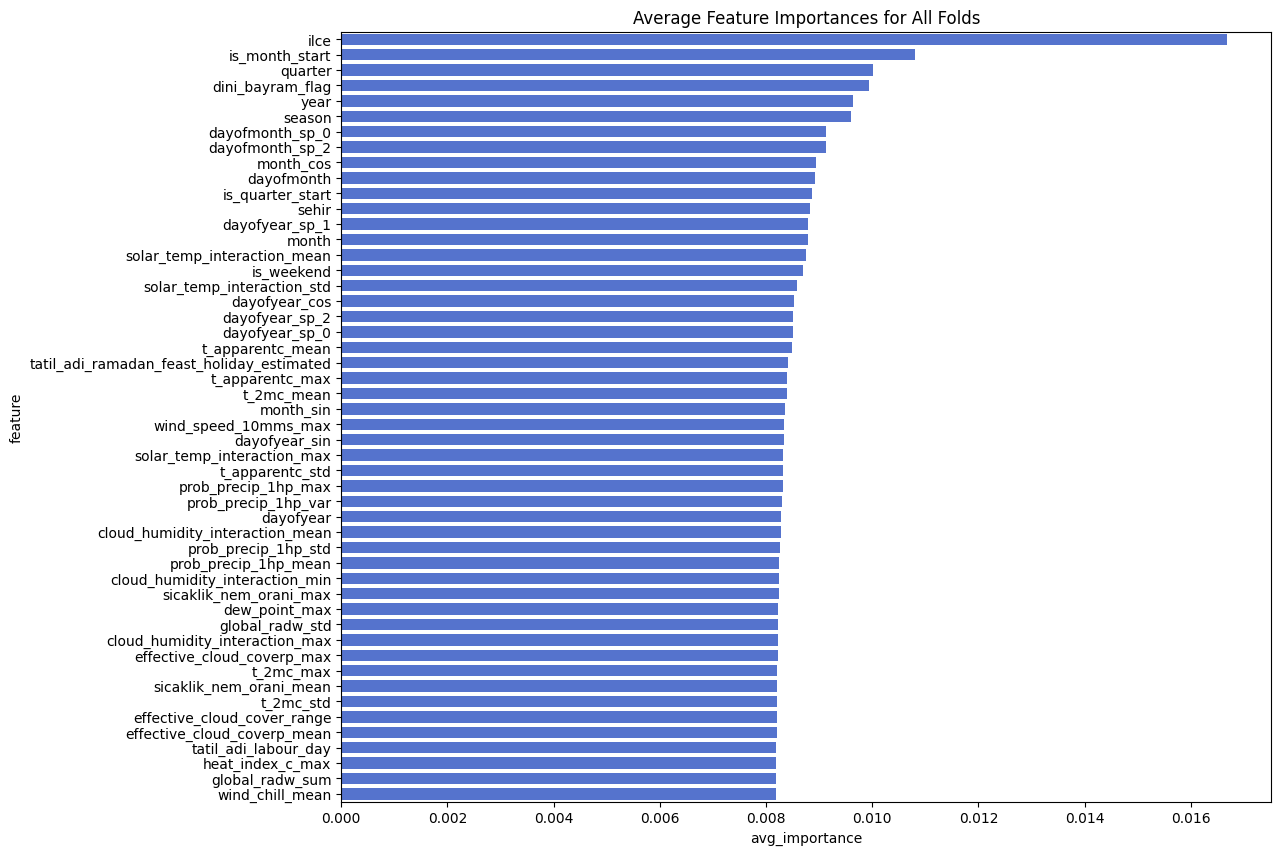

In [17]:
xgb_params = {
    'learning_rate': 0.051344106461847894,
    'max_depth': 8,
    'subsample': 0.8958383549277598,
    'colsample_bytree': 0.8396210082000671,
    'reg_alpha': 7.676457607944722,
    'reg_lambda': 8.56508940405657,
    'min_child_weight': 2.8578755365559165,
    'gamma': 3.0886900686804317
}

xgb_params["objective"] = "reg:absoluteerror"
#xgb_params["tree_method"] = "gpu_hist"
xgb_params["enable_categorical"] = True
xgb_params["n_estimators"] = 6000

model = xgb.XGBRegressor(**xgb_params)

train_params = {"early_stopping_rounds": 1000, "verbose": 250}
cv = KFold(n_splits=10, shuffle=True, random_state=45)

xgb_results = reg_trainer(
    model=model,
    X=X,
    y=y,
    X_test=X_test,
    cv=cv,
    plot_importances=True,
    train_params=train_params,
    #sample_weight=sample_weight,
    eval_metric="mae",
    log_transform=True,
    #groups = groups
)

pred_df1 = pd.DataFrame({"ilce": test_ilce, "date": test_date, "pred1": xgb_results["test_preds"]})
pred_df1["pred1"] = pred_df1["pred1"].clip(0, np.inf)

## CatBoost

n folds: 10
========================================| Fold 1 |========================================
train: (43333, 126)
val: (4815, 126)
0:	learn: 0.3660328	test: 0.3648224	best: 0.3648224 (0)	total: 136ms	remaining: 18m 10s
250:	learn: 0.2597567	test: 0.2716632	best: 0.2716632 (250)	total: 17.1s	remaining: 8m 46s
500:	learn: 0.2471681	test: 0.2685387	best: 0.2685080 (496)	total: 34.8s	remaining: 8m 40s
750:	learn: 0.2378977	test: 0.2672535	best: 0.2672512 (743)	total: 52.6s	remaining: 8m 27s
1000:	learn: 0.2306388	test: 0.2665205	best: 0.2665148 (997)	total: 1m 9s	remaining: 8m 7s
1250:	learn: 0.2246488	test: 0.2658763	best: 0.2658237 (1228)	total: 1m 27s	remaining: 7m 50s
1500:	learn: 0.2195723	test: 0.2657820	best: 0.2657579 (1492)	total: 1m 44s	remaining: 7m 30s
1750:	learn: 0.2147411	test: 0.2654271	best: 0.2653976 (1747)	total: 2m 1s	remaining: 7m 14s
2000:	learn: 0.2106613	test: 0.2653884	best: 0.2652918 (1915)	total: 2m 18s	remaining: 6m 55s
2250:	learn: 0.2069948	test: 0.26

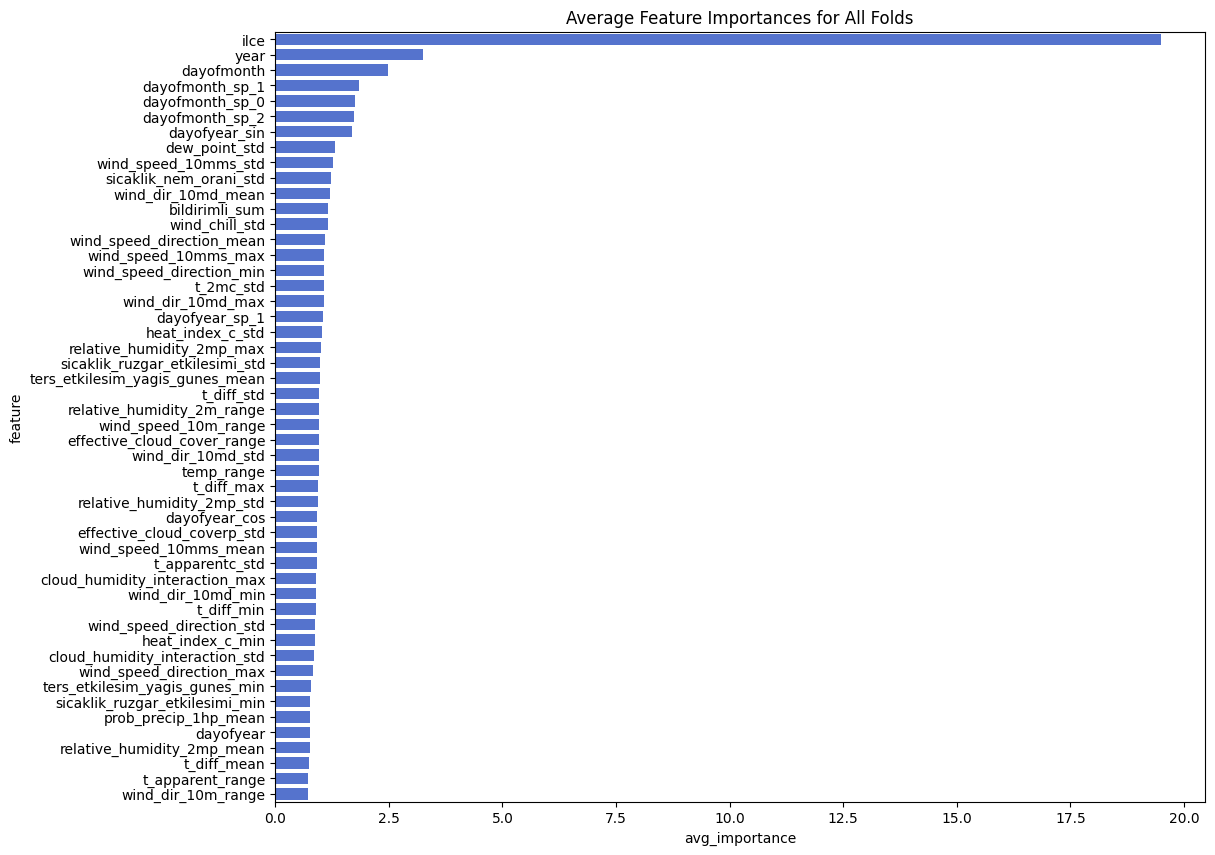

In [18]:
params = {
    'learning_rate': 0.049824800800271365,
    'objective': 'MAE',
    'depth': 7,
    'l2_leaf_reg': 1.9,
    'min_child_samples': 129,
    'iterations': 8000,
    'use_best_model': True,
    'eval_metric': "MAPE",
    'random_state': 45,
    'allow_writing_files': False,
    "cat_features": cat_cols
}

model = cb.CatBoostRegressor(**params)
train_params = {"early_stopping_rounds": 1000, "verbose": 250}
cv = KFold(n_splits=10, shuffle=True, random_state=45)

cat_results = reg_trainer(
    model=model,
    X=X,
    y=y,
    X_test=X_test,
    cv=cv,
    plot_importances=True,
    train_params=train_params,
    #sample_weight=sample_weight,
    eval_metric="mae",
    log_transform=True,
    #groups = groups
)

pred_df2 = pd.DataFrame({"ilce": test_ilce, "date": test_date, "pred2": cat_results["test_preds"]})
pred_df2["pred2"] = pred_df2["pred2"].clip(0, np.inf)

## Neural Networks

In [19]:
from sklearn.preprocessing import StandardScaler

df_encoded = pd.get_dummies(data=df, columns=cat_cols, dtype="int32")

X = df_encoded.loc[df_encoded[target].notnull()].drop(columns = drop_cols + [target], axis=1)
y = df_encoded.loc[df_encoded[target].notnull(), target]
X_test = df_encoded.loc[df_encoded[target].isnull()].drop(columns = drop_cols + [target], axis=1)
y_arr = np.array(y)

sc = StandardScaler()
train_sc = sc.fit_transform(X)
test_sc = sc.transform(X_test)
train_sc

array([[-0.60731451, -0.52920313, -0.78994195, ..., -0.56698907,
        -0.57453633, -0.56724494],
       [-0.60731451, -0.57968431, -0.6330825 , ..., -0.56698907,
        -0.57453633, -0.56724494],
       [-0.60731451, -0.60934851, -0.7787377 , ..., -0.56698907,
        -0.57453633, -0.56724494],
       ...,
       [-0.60731451, -1.89219494, -1.65266892, ..., -0.56698907,
        -0.57453633, -0.56724494],
       [-0.60731451, -1.79903896, -1.60785193, ..., -0.56698907,
        -0.57453633, -0.56724494],
       [ 0.15292206, -2.11025282, -1.88795809, ..., -0.56698907,
        -0.57453633, -0.56724494]])

In [20]:
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error,mean_absolute_error

import math
from scipy import stats

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.models import Model

from keras.metrics import MeanAbsoluteError

LOSS = tf.keras.losses.MeanAbsoluteError(
    name='mean_absolute_error'
)

METRIC = tf.keras.metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)

es = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-12, patience=10, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, verbose=1,
    mode='auto')

2024-05-13 17:34:52.042202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 17:34:52.042397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 17:34:52.217283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
def NN_model(input_shape):
    inp = layers.Input(shape=(input_shape,))

    x = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(inp)
    #x = layers.Dropout(0.1)(x)

    x = layers.Dense(units=64, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(units=64, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(x)
    #x = layers.Dropout(0.1)(x)

    x = layers.Dense(units=32, activation='relu', kernel_initializer='he_uniform')(x)

    reg_outputs = layers.Dense(units=1, activation='linear', kernel_initializer='he_uniform', name='last')(x)

    model = Model(inp, reg_outputs)

    return model

In [22]:
model = NN_model(input_shape=X.shape[1])
model.compile(loss="mean_absolute_error",
              metrics = [MeanAbsoluteError()],
              optimizer = keras.optimizers.Adam(learning_rate=0.0012))

model.fit(train_sc,
          y_arr,
          batch_size=512,
          epochs=25,
          #validation_data=(x_val, y_val),
          callbacks=[es, plateau],
          verbose=1)

Epoch 1/25
95/95 [==============================] - 2s 8ms/step - loss: 3.4088 - mean_absolute_error: 3.4088 - lr: 0.0012
Epoch 2/25
95/95 [==============================] - 1s 7ms/step - loss: 2.8664 - mean_absolute_error: 2.8664 - lr: 0.0012
Epoch 3/25
95/95 [==============================] - 1s 7ms/step - loss: 2.7982 - mean_absolute_error: 2.7982 - lr: 0.0012
Epoch 4/25
95/95 [==============================] - 1s 7ms/step - loss: 2.7581 - mean_absolute_error: 2.7581 - lr: 0.0012
Epoch 5/25
95/95 [==============================] - 1s 7ms/step - loss: 2.7234 - mean_absolute_error: 2.7234 - lr: 0.0012
Epoch 6/25
95/95 [==============================] - 1s 7ms/step - loss: 2.6933 - mean_absolute_error: 2.6933 - lr: 0.0012
Epoch 7/25
95/95 [==============================] - 1s 7ms/step - loss: 2.6664 - mean_absolute_error: 2.6664 - lr: 0.0012
Epoch 8/25
95/95 [==============================] - 1s 7ms/step - loss: 2.6486 - mean_absolute_error: 2.6486 - lr: 0.0012
Epoch 9/25
95/95 [======

- 2.5849
- 2.5738
- 2.4902

In [23]:
nn_preds = model.predict(test_sc)

43/43 [==============================] - 0s 2ms/step


In [24]:
xgb_w = 0.22
cat_w = 0.34
prop_w = 0.32
nn_w = 0.12

final_preds = pred_df1["pred1"].values * xgb_w + pred_df2["pred2"].values * cat_w + prophet_preds["prophet_pred"].values * prop_w + nn_preds.ravel() * nn_w

In [25]:
sample_submission = pd.read_csv(config.sample_submission_path)

sample_submission["bildirimsiz_sum"] = final_preds
sample_submission["bildirimsiz_sum"] = sample_submission["bildirimsiz_sum"].clip(0, np.inf).astype("int32")

#sample_submission.to_csv("submission.csv", index=False)

In [26]:
sample_submission.head(10)

,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,4
1,2024-02-01-izmir-bayindir,2
2,2024-02-01-izmir-bayrakli,3
3,2024-02-01-izmir-bergama,5
4,2024-02-01-izmir-bornova,6
5,2024-02-01-izmir-buca,4
6,2024-02-01-izmir-cesme,10
7,2024-02-01-izmir-cigli,2
8,2024-02-01-izmir-dikili,3
9,2024-02-01-izmir-foca,3


In [27]:
sample_submission.to_csv(f"submission_xgb{xgb_w}_cat{cat_w}_prop{prop_w}_nn{nn_w}.csv", index=False)